# Sleep, Physical Activity, and Depressive Symptoms

This notebook explores the relationship between measured sleep and physical activity (via Fitbit data) and depressive symptom severity measured bythe Beck Depression Inventory-II (BDI-II).

The goal is to understand whether behavioral signals captured by wearables are meaningfully associated with mental health outcomes.

## Research Questions and Hypotheses

**Research Questions**
- Is sleep duration associated with depressive symptom severity?
- Is physical activity (step count) associated with depressive symptom severity?

**Hypotheses**
- Lower sleep duration will be associated with higher BDI-II scores.
- Physical activity will show a weaker association with depressive symptoms than sleep.


## Data Preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm


In [3]:
pre = pd.read_csv("pre.csv")
post = pd.read_csv("post.csv")
weekly = pd.read_csv("dep_weekly.csv")
ema = pd.read_csv("ema.csv")
endterm = pd.read_csv("dep_endterm.csv")
sleep = pd.read_csv("sleep.csv")
activity = pd.read_csv("steps.csv")

In [ ]:
datasets = {
    "pre": pre,
    "post": post,
    "weekly": weekly,
    "ema": ema,
    "endterm": endterm,
    "sleep": sleep,
    "activity": activity
    
}

for name, df in datasets.items():
    print(f"\n{name.upper()}")
    print(df.shape)
    display(df.head())


### Filtered sleep features to include only daily and 7-day summaries, excluding normalized and discretized columns.

In [5]:
id_cols = ["pid", "date"]

sleep_keep = id_cols + [
    c for c in sleep.columns
    if (
        (c.endswith(":allday") or c.endswith(":7dhist"))
        and "_norm" not in c
        and "_dis" not in c
    )
]


### Removed intraday sleep features to focus on daily and 7-day summaries.

In [ ]:
sleep_sub = sleep[sleep_keep].copy()
sleep_sub = sleep_sub.loc[
    :, ~sleep_sub.columns.str.contains("intraday")
]

sleep_sub.head()



### Repeating the process with steps activity

In [ ]:
activity_keep = id_cols + [
    c for c in activity.columns
    if (
        (c.endswith(":allday") or c.endswith(":7dhist"))
        and "_norm" not in c
        and "_dis" not in c
    )
]

activity_sub = activity[activity_keep].copy()


activity_sub = activity_sub.loc[
    :, ~activity_sub.columns.str.contains("intraday")
]

activity_sub.head()


### Merging the sleep and steps data using PID and Date

In [ ]:
sleep_activity = sleep_sub.merge(
    activity_sub,
    on=["pid", "date"],
    how="inner"
)
sleep_activity.shape
sleep_activity.head()


In [ ]:
sleep_activity_end = sleep_activity.merge(
    endterm[["pid", "date", "BDI2"]],
    on=["pid", "date"],
    how="inner"
)

sleep_activity_end.head()

### What fraction of rows is missing for my new dataset 

In [ ]:
sleep_activity_end.isna().mean().sort_values(ascending=False)

In [11]:
sleep_activity_end = sleep_activity_end.loc[
    :, sleep_activity_end.isna().mean() < 0.95
]


## Sleep and Depressive Symptoms

To examine the relationship between sleep and depression, I analyzed total sleep duration measured over a 7-day rolling window and compared it to BDI-II scores.

The scatter plot below visualizes the relationship between average sleep duration and depressive symptom severity.


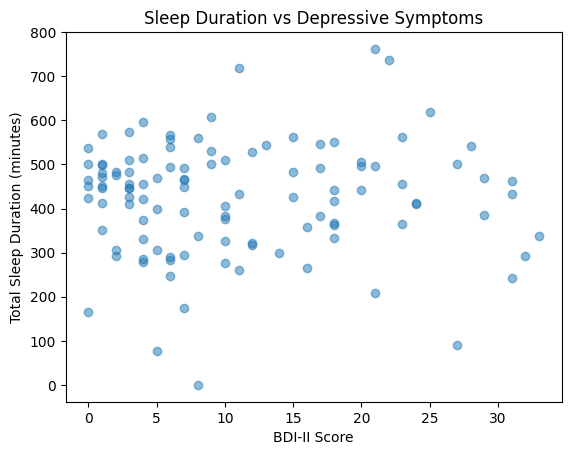

In [12]:
plt.scatter(
    sleep_activity_end["BDI2"],
    sleep_activity_end["f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday"],
    alpha=0.5
)

plt.ylabel("Total Sleep Duration (minutes)")
plt.xlabel("BDI-II Score")
plt.title("Sleep Duration vs Depressive Symptoms")
plt.show()


The scatterplot shows substantial variability in sleep duration across all BDI-II scores, with no clear linear trend. However, higher depressive symptom scores appear more frequently among individuals with shorter or more variable sleep duration.


## Physical Activity and Depressive Symptoms

Physical activity was measured using average daily step count. I examined whether higher levels of physical activity were associated with lower BDI-II scores.


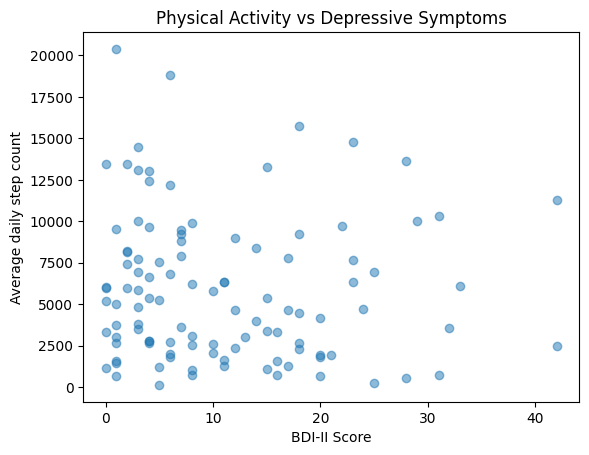

In [13]:
plt.scatter(
    sleep_activity_end["BDI2"],
    sleep_activity_end["f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday"],
    alpha=0.5
)

plt.ylabel("Average daily step count")
plt.xlabel("BDI-II Score")
plt.title("Physical Activity vs Depressive Symptoms")
plt.show()


In contrast, average daily step count shows no clear monotonic relationship with depressive symptoms. Individuals with both high and low BDI-II scores exhibit a wide range of activity levels.



In [14]:
sleep_activity_end["depressed"] = sleep_activity_end["BDI2"] >= 14

sleep_activity_end.groupby("depressed")[
    [
        "f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday",
        "f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday"
    ]
].mean()


,f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday,f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday
depressed,,
False,418.671233,6055.130435
True,434.710526,5492.894737


## Regression Analysis (OLS)

To quantify the relationships observed visually, I used the regression results between sleep duration, step count, and BDI-II to answer when considering sleep and physical activity together, which one explains depressive symptoms?

In [15]:
X = sleep_activity_end[
    [
        "f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:7dhist",
        "f_steps:fitbit_steps_summary_rapids_avgsumsteps:7dhist"
    ]
]

X = sm.add_constant(X)
y = sleep_activity_end["BDI2"]

model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   BDI2   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.897
Date:                Fri, 30 Jan 2026   Prob (F-statistic):             0.0582
Time:                        16:58:44   Log-Likelihood:                -591.28
No. Observations:                 159   AIC:                             1189.
Df Residuals:                     156   BIC:                             1198.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

Sleep duration showed a weak negative correlation with depressive symptoms, while step count showed no statistically significant association.

## Depression Severity Groups

To improve further interpretation, I groupd BDI-II scores were using standard clinical cutoffs:

- 0–13: Minimal
- 14–19: Mild
- 20–28: Moderate
- 29+: Severe

This allows comparison of sleep patterns across meaningful symptom categories.


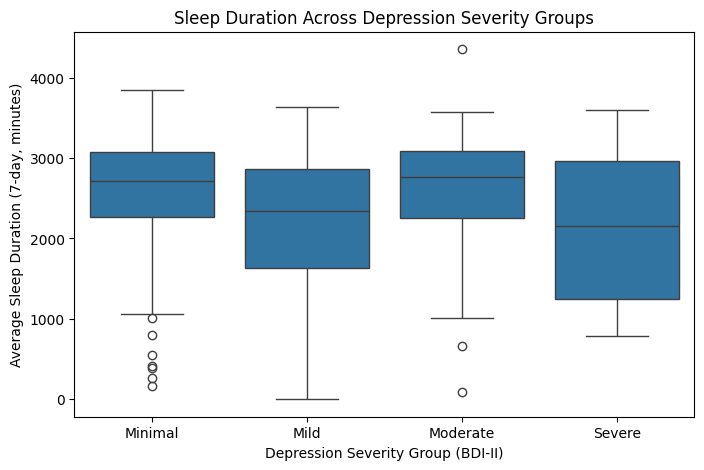

In [16]:
sleep_activity_end["bdi_group"] = pd.cut(
    sleep_activity_end["BDI2"],
    bins=[-1, 13, 19, 28, 63],
    labels=["Minimal", "Mild", "Moderate", "Severe"]
)

sleep_activity_end.groupby("bdi_group")[
    "f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:7dhist"
].mean()

plt.figure(figsize=(8,5))
sns.boxplot(
    x="bdi_group",
    y="f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:7dhist",
    data=sleep_activity_end
)
plt.xlabel("Depression Severity Group (BDI-II)")
plt.ylabel("Average Sleep Duration (7-day, minutes)")
plt.title("Sleep Duration Across Depression Severity Groups")
plt.show()



In [17]:
sleep_activity_end.groupby("bdi_group")[
    "f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:7dhist"
].agg(["mean", "median", "std", "count"])


,mean,median,std,count
bdi_group,,,,
Minimal,2529.968421,2717.0,812.020522,95
Mild,2202.406250,2342.0,905.285478,32
Moderate,2520.500000,2758.5,1009.775022,22
Severe,2109.928571,2149.0,976.984014,14


The boxplot shows that individuals in higher depression severity groups tend to have lower median sleep duration and greater variability in sleep patterns. This suggests that disrupted or insufficient sleep may be associated with more severe depressive symptoms, although substantial overlap exists between groups.


## Conclusion

This analysis suggests that sleep duration has a modest association with depressive symptom severity, while physical activity shows little relationship. Wearable data may provide useful behavioral signals, but alone are insufficient to explain mental health outcomes.
